In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported")

Libraries imported


## Load Data

In [2]:
# Load cleaned dataset
df = pd.read_csv('../data/obesity_data_cleaned.csv')
print(f"Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Loaded: 93505 rows, 33 columns


,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$15,000 - $24,999",INC,INC1525
1,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$25,000 - $34,999",INC,INC2535
2,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$35,000 - $49,999",INC,INC3550
3,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$50,000 - $74,999",INC,INC5075
4,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$75,000 or greater",INC,INC75PLUS


## Feature Engineering

In [3]:
# Create working copy
df_model = df.copy()
target = 'Data_Value'

# Remove missing targets
df_model = df_model.dropna(subset=[target])
print(f"Dataset shape: {df_model.shape}")

Dataset shape: (93505, 33)


In [4]:
# Create engineered features
df_model['Years_Since_Start'] = df_model['YearStart'] - df_model['YearStart'].min()
df_model['Confidence_Range'] = df_model['High_Confidence_Limit '] - df_model['Low_Confidence_Limit']
df_model['Sample_Size_Category'] = pd.cut(df_model['Sample_Size'], 
                                            bins=[0, 500, 1000, 2000, 5000, 100000],
                                            labels=['Very_Small', 'Small', 'Medium', 'Large', 'Very_Large'])

# Ordinal encoding for demographics
income_order = {'Less than $15,000': 1, '$15,000 - $24,999': 2, '$25,000 - $34,999': 3,
                '$35,000 - $49,999': 4, '$50,000 - $74,999': 5, '$75,000 or greater': 6}
df_model['Income_Level'] = df_model['Income'].map(income_order)

education_order = {'Less than high school': 1, 'High school graduate': 2,
                   'Some college or technical school': 3, 'College graduate': 4}
df_model['Education_Level'] = df_model['Education'].map(education_order)

age_order = {'18 - 24': 1, '25 - 34': 2, '35 - 44': 3, '45 - 54': 4, '55 - 64': 5, '65 or older': 6}
df_model['Age_Group'] = df_model['Age(years)'].map(age_order)

print("Features engineered")

Features engineered


In [5]:
# Encode categorical variables
le = LabelEncoder()
df_model['State_Encoded'] = le.fit_transform(df_model['LocationDesc'])
sex_mapping = {'Male': 0, 'Female': 1}
df_model['Sex_Encoded'] = df_model['Sex'].map(sex_mapping)
df_model['Race_Encoded'] = le.fit_transform(df_model['Race/Ethnicity'].fillna('Unknown'))

print("Categorical encoding complete")

Categorical encoding complete


In [6]:
# Select features and handle missing values
feature_columns = ['YearStart', 'Years_Since_Start', 'Low_Confidence_Limit', 'High_Confidence_Limit ',
                   'Confidence_Range', 'Sample_Size', 'State_Encoded']

# Fill missing demographics with indicator values
df_model['Income_Level_Filled'] = df_model['Income_Level'].fillna(0)
df_model['Education_Level_Filled'] = df_model['Education_Level'].fillna(0)
df_model['Age_Group_Filled'] = df_model['Age_Group'].fillna(0)
df_model['Sex_Encoded_Filled'] = df_model['Sex_Encoded'].fillna(2)
df_model['Race_Encoded_Filled'] = df_model['Race_Encoded'].fillna(df_model['Race_Encoded'].max() + 1)

feature_columns_extended = feature_columns + ['Income_Level_Filled', 'Education_Level_Filled', 
                                               'Age_Group_Filled', 'Sex_Encoded_Filled', 'Race_Encoded_Filled']

# Create final dataset
df_complete = df_model[feature_columns_extended + [target]].dropna()
X = df_complete[feature_columns_extended]
y = df_complete[target]

print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")

Final dataset: 93505 samples, 12 features


Feature correlations with target:
Low_Confidence_Limit      0.957526
High_Confidence_Limit     0.944549
Confidence_Range          0.140806
Years_Since_Start         0.110326
YearStart                 0.110326
Age_Group_Filled          0.024017
Income_Level_Filled       0.009717
Race_Encoded_Filled       0.005092
State_Encoded            -0.002977
Sample_Size              -0.004192
Education_Level_Filled   -0.012315
Sex_Encoded_Filled       -0.014194
dtype: float64


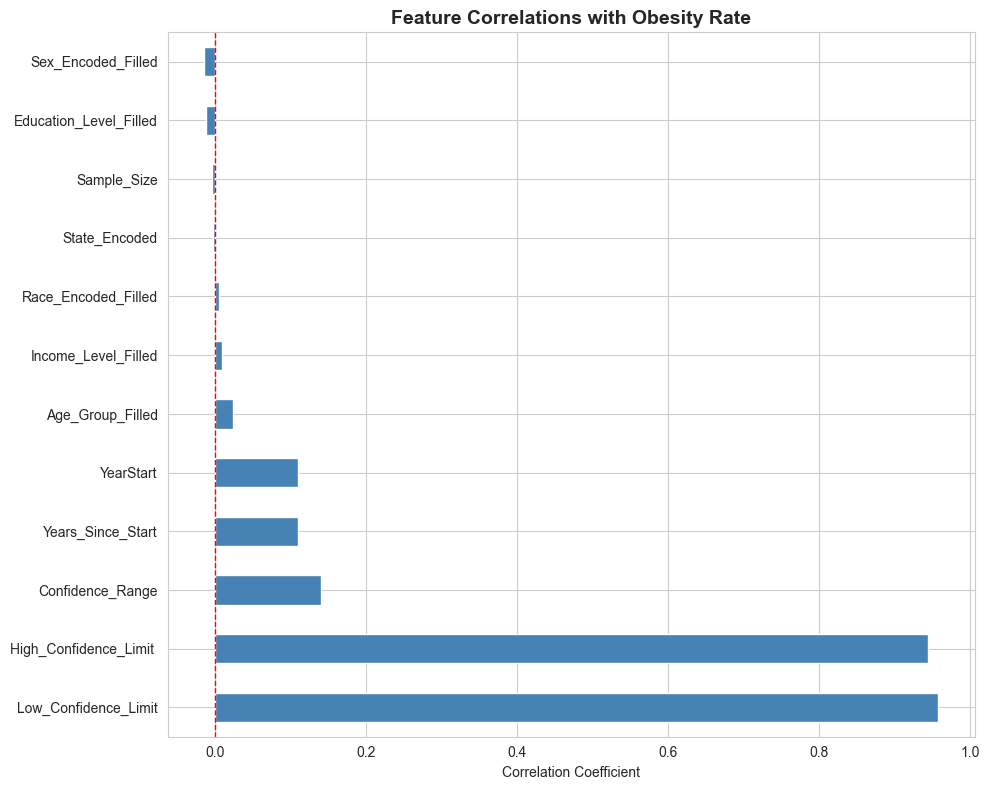

In [7]:
# Feature correlations
correlations = X.corrwith(y).sort_values(ascending=False)
print("Feature correlations with target:")
print(correlations)

plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color='steelblue')
plt.title('Feature Correlations with Obesity Rate', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('../screenshots/feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

## Train-Test Split

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")

Training: 74804 samples
Testing: 18701 samples


In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling complete")

Feature scaling complete


## Build Models

In [10]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)

print("Linear Regression Results:")
print(f"  Train R²: {lr_train_r2:.4f}, RMSE: {lr_train_rmse:.4f}, MAE: {lr_train_mae:.4f}")
print(f"  Test R²: {lr_test_r2:.4f}, RMSE: {lr_test_rmse:.4f}, MAE: {lr_test_mae:.4f}")

Linear Regression Results:
  Train R²: 0.9989, RMSE: 0.3410, MAE: 0.1768
  Test R²: 0.9989, RMSE: 0.3474, MAE: 0.1767


In [11]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_train_r2 = r2_score(y_train, y_train_pred_ridge)
ridge_test_r2 = r2_score(y_test, y_test_pred_ridge)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
ridge_train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
ridge_test_mae = mean_absolute_error(y_test, y_test_pred_ridge)

print("Ridge Regression Results:")
print(f"  Train R²: {ridge_train_r2:.4f}, RMSE: {ridge_train_rmse:.4f}, MAE: {ridge_train_mae:.4f}")
print(f"  Test R²: {ridge_test_r2:.4f}, RMSE: {ridge_test_rmse:.4f}, MAE: {ridge_test_mae:.4f}")

Ridge Regression Results:
  Train R²: 0.9989, RMSE: 0.3410, MAE: 0.1768
  Test R²: 0.9989, RMSE: 0.3474, MAE: 0.1766


In [12]:
# Lasso Regression
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)

lasso_train_r2 = r2_score(y_train, y_train_pred_lasso)
lasso_test_r2 = r2_score(y_test, y_test_pred_lasso)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
lasso_train_mae = mean_absolute_error(y_train, y_train_pred_lasso)
lasso_test_mae = mean_absolute_error(y_test, y_test_pred_lasso)

non_zero_features = np.sum(lasso_model.coef_ != 0)
print("Lasso Regression Results:")
print(f"  Train R²: {lasso_train_r2:.4f}, RMSE: {lasso_train_rmse:.4f}, MAE: {lasso_train_mae:.4f}")
print(f"  Test R²: {lasso_test_r2:.4f}, RMSE: {lasso_test_rmse:.4f}, MAE: {lasso_test_mae:.4f}")
print(f"  Features selected: {non_zero_features}/{len(X_train.columns)}")

Lasso Regression Results:
  Train R²: 0.9988, RMSE: 0.3619, MAE: 0.1672
  Test R²: 0.9987, RMSE: 0.3685, MAE: 0.1678
  Features selected: 2/12


## Cross-Validation

In [13]:
# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=kfold, scoring='r2')
lr_cv_rmse = np.sqrt(-cross_val_score(lr_model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error'))

ridge_cv_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=kfold, scoring='r2')
ridge_cv_rmse = np.sqrt(-cross_val_score(ridge_model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error'))

lasso_cv_scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=kfold, scoring='r2')
lasso_cv_rmse = np.sqrt(-cross_val_score(lasso_model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error'))

print("Cross-Validation Results:")
print(f"Linear:  R² = {lr_cv_scores.mean():.4f} ± {lr_cv_scores.std():.4f}")
print(f"Ridge:   R² = {ridge_cv_scores.mean():.4f} ± {ridge_cv_scores.std():.4f}")
print(f"Lasso:   R² = {lasso_cv_scores.mean():.4f} ± {lasso_cv_scores.std():.4f}")

Cross-Validation Results:
Linear:  R² = 0.9989 ± 0.0000
Ridge:   R² = 0.9989 ± 0.0000
Lasso:   R² = 0.9988 ± 0.0000


## Model Comparison

In [14]:
# Compare models
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Train_R2': [lr_train_r2, ridge_train_r2, lasso_train_r2],
    'Test_R2': [lr_test_r2, ridge_test_r2, lasso_test_r2],
    'Train_RMSE': [lr_train_rmse, ridge_train_rmse, lasso_train_rmse],
    'Test_RMSE': [lr_test_rmse, ridge_test_rmse, lasso_test_rmse],
    'CV_R2_Mean': [lr_cv_scores.mean(), ridge_cv_scores.mean(), lasso_cv_scores.mean()]
})

print("Model Comparison:")
print(results_df)
print(f"\nBest Model: {results_df.loc[results_df['Test_R2'].idxmax(), 'Model']}")

Model Comparison:
               Model  Train_R2   Test_R2  Train_RMSE  Test_RMSE  CV_R2_Mean
0  Linear Regression  0.998933  0.998871    0.340950   0.347365    0.998932
1   Ridge Regression  0.998933  0.998871    0.340950   0.347366    0.998932
2   Lasso Regression  0.998797  0.998730    0.361945   0.368462    0.998797

Best Model: Linear Regression


## Visualizations

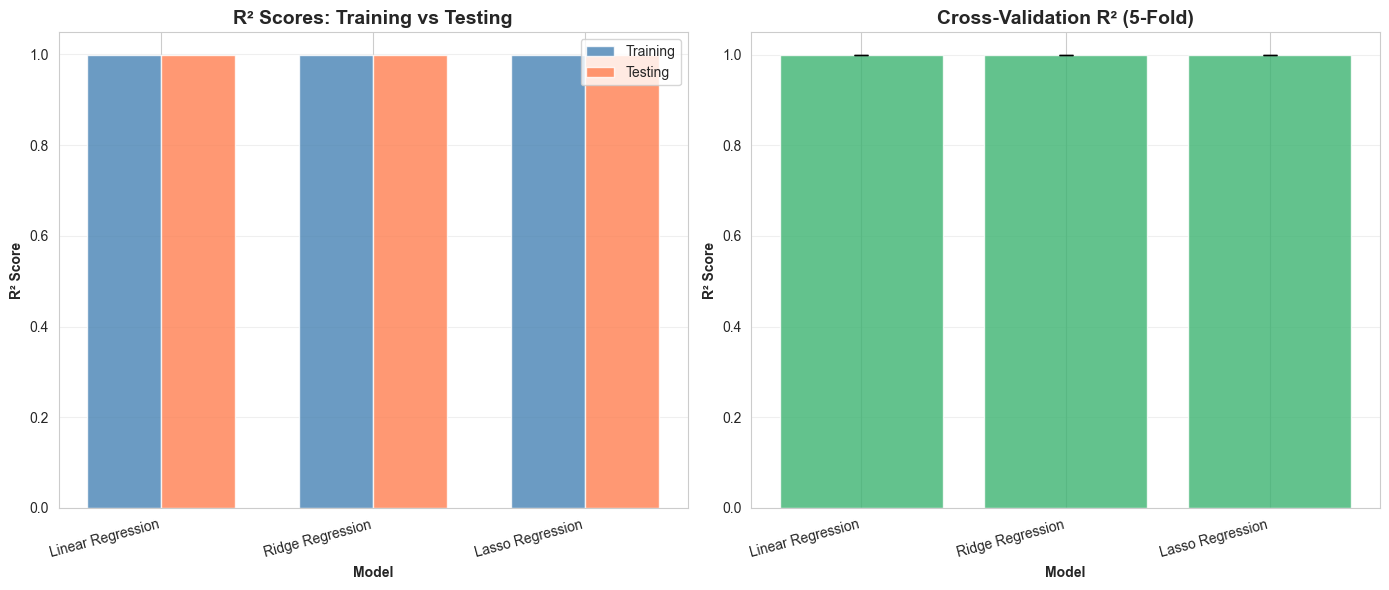

In [15]:
# R² Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

models = results_df['Model']
x_pos = np.arange(len(models))
width = 0.35

ax1.bar(x_pos - width/2, results_df['Train_R2'], width, label='Training', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, results_df['Test_R2'], width, label='Testing', color='coral', alpha=0.8)
ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('R² Scores: Training vs Testing', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2.bar(x_pos, [lr_cv_scores.mean(), ridge_cv_scores.mean(), lasso_cv_scores.mean()], color='mediumseagreen', alpha=0.8)
ax2.errorbar(x_pos, [lr_cv_scores.mean(), ridge_cv_scores.mean(), lasso_cv_scores.mean()], 
             yerr=[lr_cv_scores.std(), ridge_cv_scores.std(), lasso_cv_scores.std()], 
             fmt='none', color='black', capsize=5, linewidth=2)
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('R² Score', fontweight='bold')
ax2.set_title('Cross-Validation R² (5-Fold)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../screenshots/r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

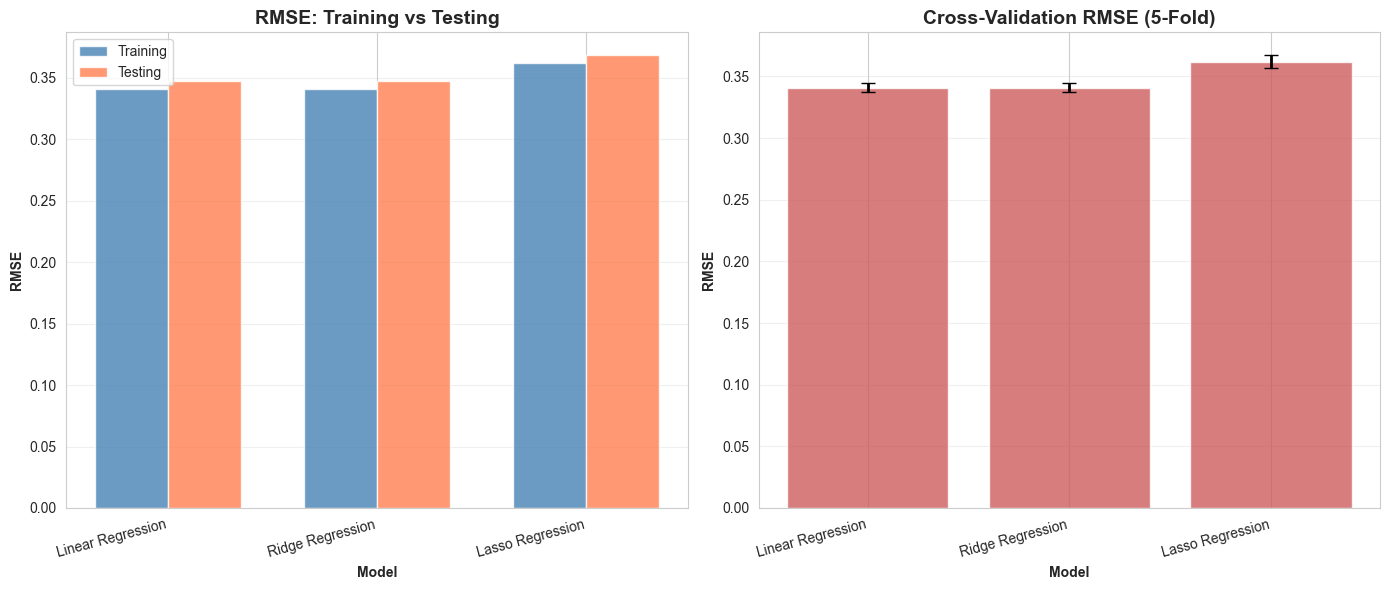

In [16]:
# RMSE Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.bar(x_pos - width/2, results_df['Train_RMSE'], width, label='Training', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, results_df['Test_RMSE'], width, label='Testing', color='coral', alpha=0.8)
ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('RMSE', fontweight='bold')
ax1.set_title('RMSE: Training vs Testing', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2.bar(x_pos, [lr_cv_rmse.mean(), ridge_cv_rmse.mean(), lasso_cv_rmse.mean()], color='indianred', alpha=0.8)
ax2.errorbar(x_pos, [lr_cv_rmse.mean(), ridge_cv_rmse.mean(), lasso_cv_rmse.mean()],
             yerr=[lr_cv_rmse.std(), ridge_cv_rmse.std(), lasso_cv_rmse.std()],
             fmt='none', color='black', capsize=5, linewidth=2)
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('RMSE', fontweight='bold')
ax2.set_title('Cross-Validation RMSE (5-Fold)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../screenshots/rmse_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

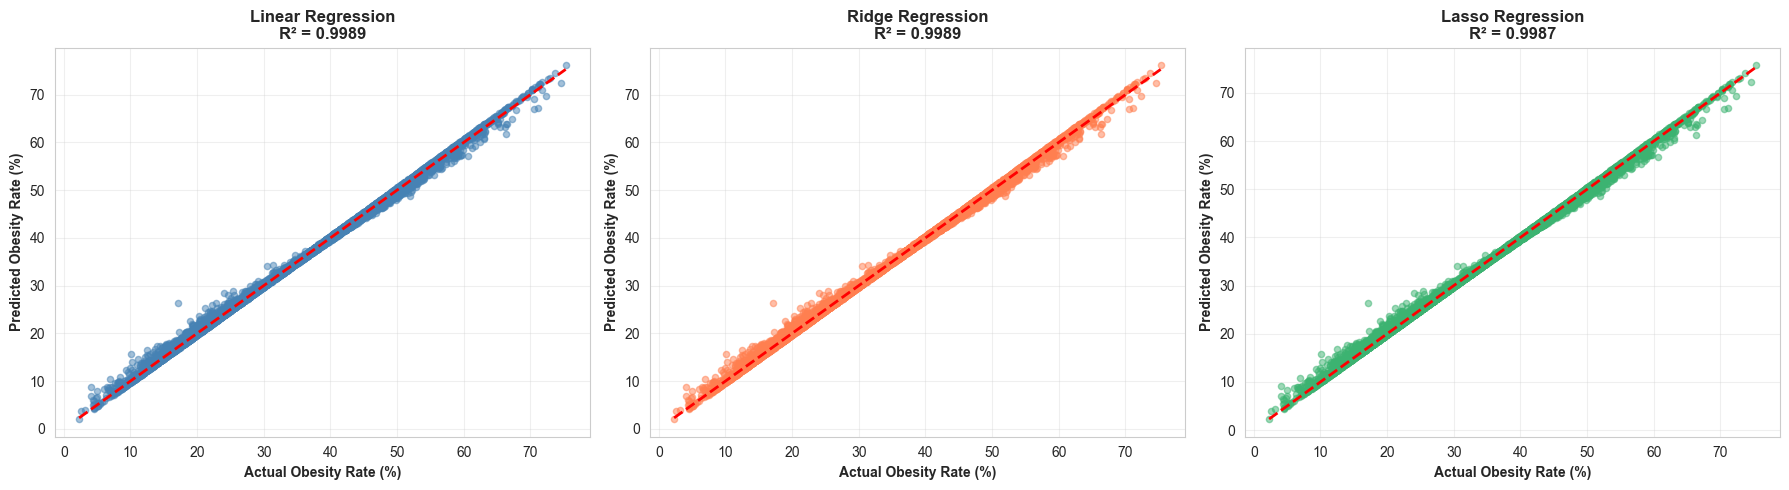

In [17]:
# Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test, y_test_pred_lr, alpha=0.5, color='steelblue', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Obesity Rate (%)', fontweight='bold')
axes[0].set_ylabel('Predicted Obesity Rate (%)', fontweight='bold')
axes[0].set_title(f'Linear Regression\nR² = {lr_test_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test, y_test_pred_ridge, alpha=0.5, color='coral', s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Obesity Rate (%)', fontweight='bold')
axes[1].set_ylabel('Predicted Obesity Rate (%)', fontweight='bold')
axes[1].set_title(f'Ridge Regression\nR² = {ridge_test_r2:.4f}', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].scatter(y_test, y_test_pred_lasso, alpha=0.5, color='mediumseagreen', s=20)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Obesity Rate (%)', fontweight='bold')
axes[2].set_ylabel('Predicted Obesity Rate (%)', fontweight='bold')
axes[2].set_title(f'Lasso Regression\nR² = {lasso_test_r2:.4f}', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../screenshots/predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

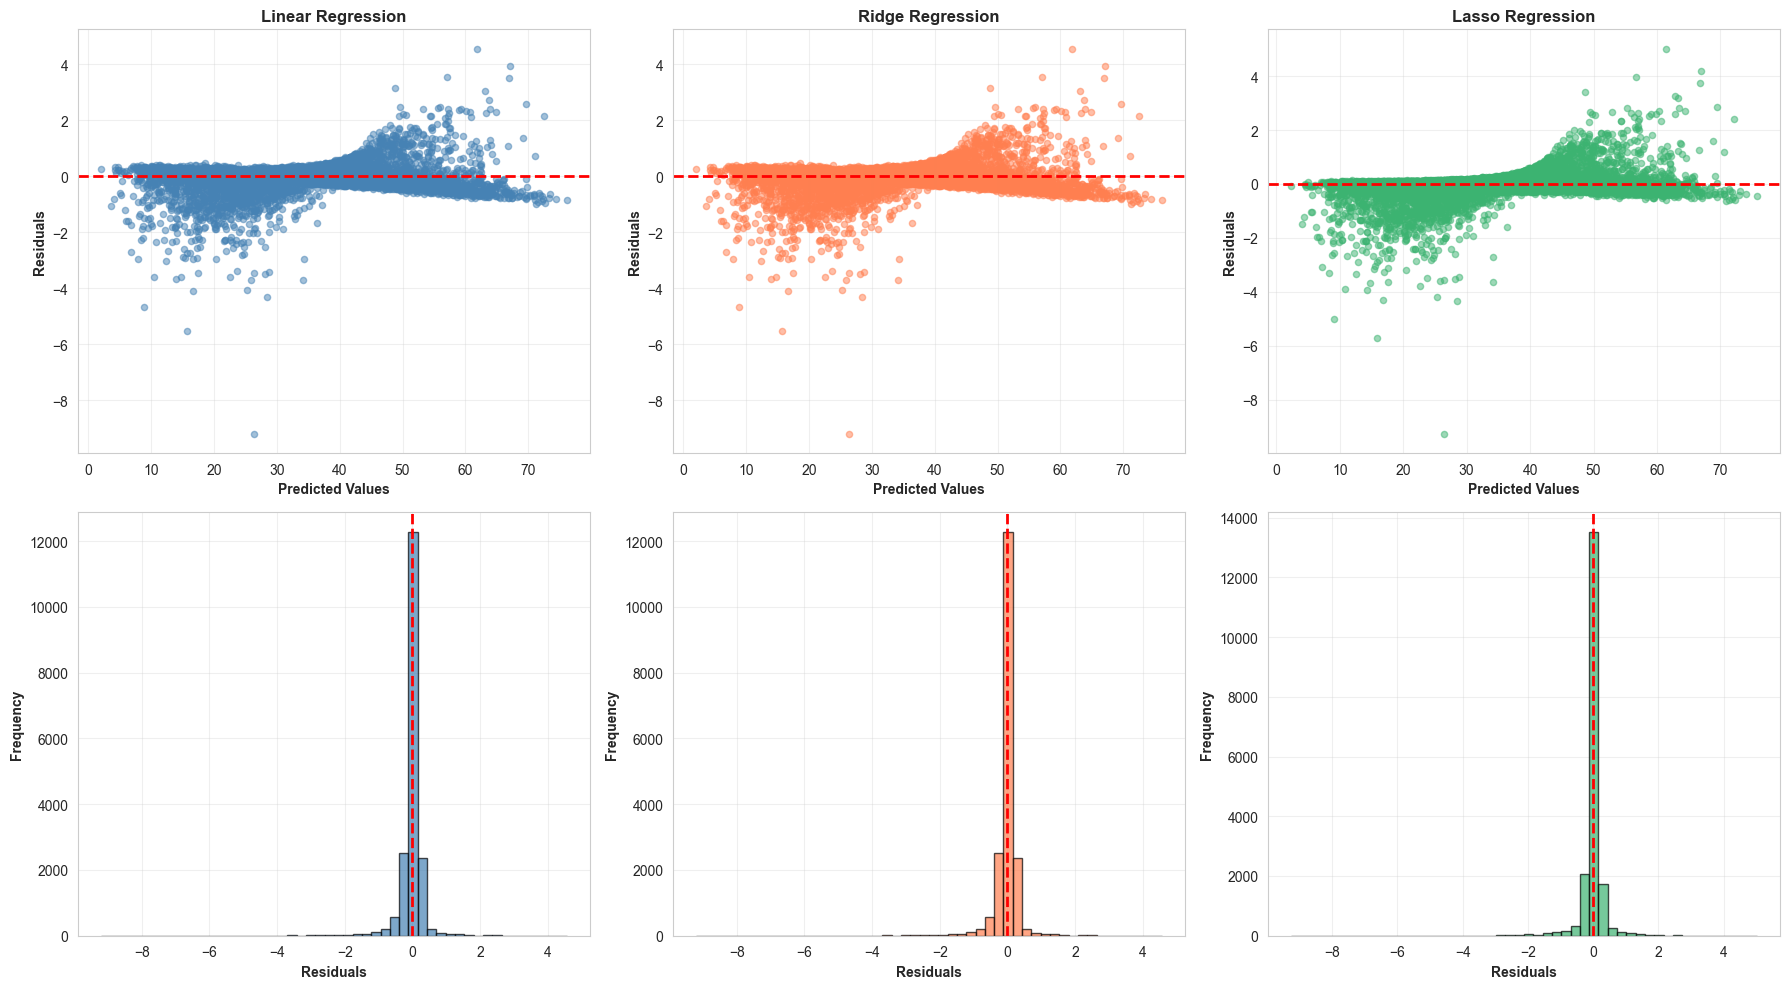

In [18]:
# Residual Analysis
lr_residuals = y_test - y_test_pred_lr
ridge_residuals = y_test - y_test_pred_ridge
lasso_residuals = y_test - y_test_pred_lasso

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].scatter(y_test_pred_lr, lr_residuals, alpha=0.5, color='steelblue', s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Values', fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontweight='bold')
axes[0, 0].set_title('Linear Regression', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].scatter(y_test_pred_ridge, ridge_residuals, alpha=0.5, color='coral', s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values', fontweight='bold')
axes[0, 1].set_ylabel('Residuals', fontweight='bold')
axes[0, 1].set_title('Ridge Regression', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[0, 2].scatter(y_test_pred_lasso, lasso_residuals, alpha=0.5, color='mediumseagreen', s=20)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Predicted Values', fontweight='bold')
axes[0, 2].set_ylabel('Residuals', fontweight='bold')
axes[0, 2].set_title('Lasso Regression', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

axes[1, 0].hist(lr_residuals, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(ridge_residuals, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

axes[1, 2].hist(lasso_residuals, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Residuals', fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../screenshots/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

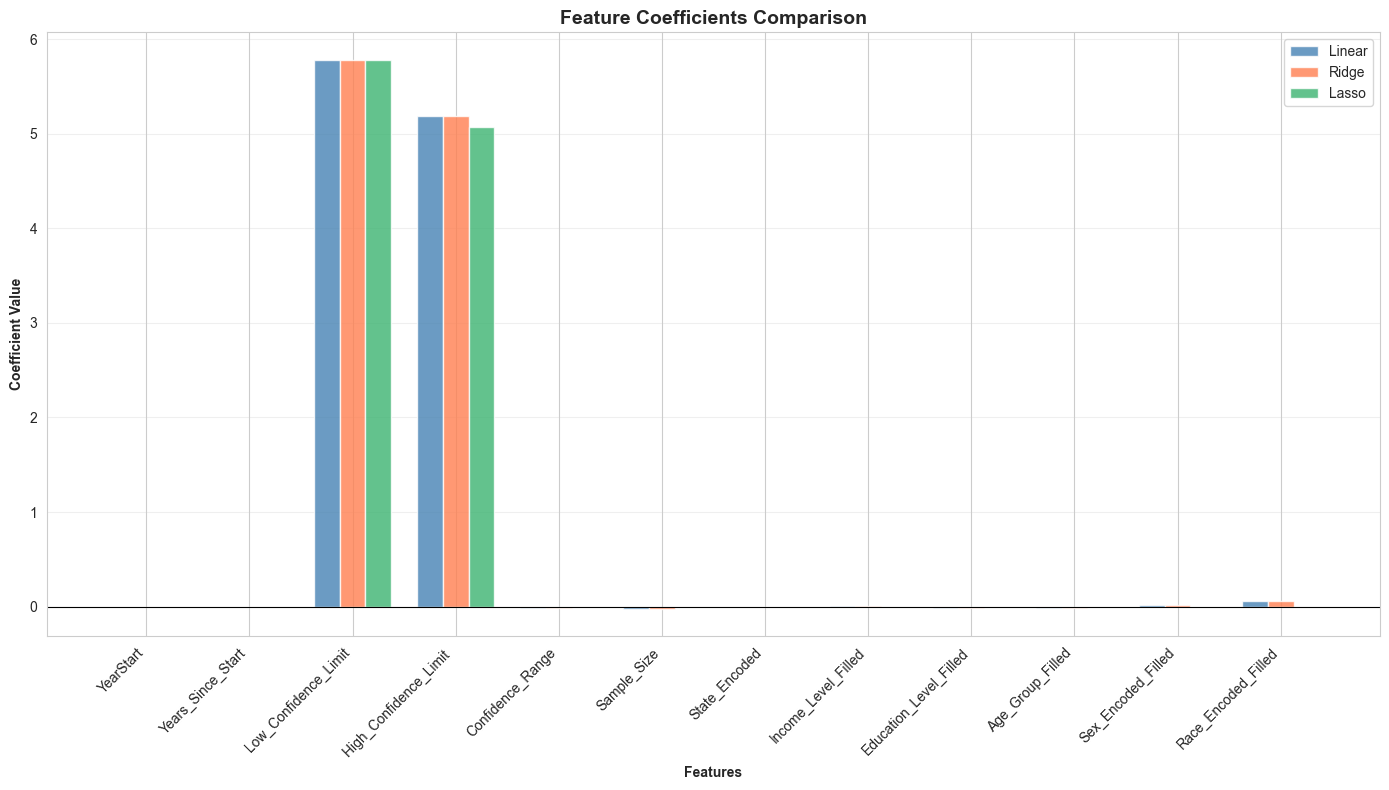


All visualizations saved to screenshots/


In [19]:
# Feature Coefficients
coef_comparison = pd.DataFrame({
    'Feature': X_train.columns,
    'Linear': lr_model.coef_,
    'Ridge': ridge_model.coef_,
    'Lasso': lasso_model.coef_
})

fig, ax = plt.subplots(figsize=(14, 8))
x_pos = np.arange(len(coef_comparison))
width = 0.25

ax.bar(x_pos - width, coef_comparison['Linear'], width, label='Linear', color='steelblue', alpha=0.8)
ax.bar(x_pos, coef_comparison['Ridge'], width, label='Ridge', color='coral', alpha=0.8)
ax.bar(x_pos + width, coef_comparison['Lasso'], width, label='Lasso', color='mediumseagreen', alpha=0.8)

ax.set_xlabel('Features', fontweight='bold')
ax.set_ylabel('Coefficient Value', fontweight='bold')
ax.set_title('Feature Coefficients Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(coef_comparison['Feature'], rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../screenshots/coefficient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll visualizations saved to screenshots/")